In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import matplotlib.cm as cm

from scipy.spatial.distance import cdist

import json

from os.path import join

In [14]:
ARTIST_PATH = './artist_df.csv'
artist_df = pd.read_csv(ARTIST_PATH)

In [9]:
def make_artist_graph(path, similarity_matrix=None, edge_weight_threshold=0.1):
    artist_df = pd.read_csv(path)
    # aid -> artist id
    # nid -> node id
    aid_nid_map = {}
    def add_aid_nid_mapping(aid_nid_map, aid, nid):
        aid_nid_map[aid] = nid
        return nid
    artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
    nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
    nid_list = artist_df['node_id'].tolist()
    artist_graph = nx.Graph()
    artist_graph.add_nodes_from(artist_df['node_id'].tolist())
    edge_attribute_list = []
    if type(similarity_matrix) != type(None):
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                edge_weight = similarity_matrix[nid, other_nid]
                if abs(edge_weight) > edge_weight_threshold:
                    weight_dict = {'weight': edge_weight}
                    edge = (nid, other_nid, weight_dict)
                    edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    else:
        # Add the node attributes to the graph
        node_attrs_dict = {}
        for nid in nid_list:
            row = artist_df.iloc[nid]
            artist_attr_dict = {
                'artist_name': row['artist_name'],
                'total_plays': row['total_plays'],
                'num_listeners': row['num_listeners'],
                'play_ratio': row['play_ratio']
            }
            genres = row['genres'].replace("[", "").replace("]", "").replace("\'", "").split(', ')
            track_freq = json.loads(row['track_freq'].replace("\'", "\""))
            top_listeners = json.loads(row['top_listeners'].replace("\'", "\""))
            artist_attr_dict['genres'], artist_attr_dict['track_freq'], artist_attr_dict['top_listeners'] = \
            genres, track_freq, top_listeners
            node_attrs_dict[nid] = artist_attr_dict
        nx.set_node_attributes(artist_graph, node_attrs_dict)
        # create edge attributes and add them to the graph
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                nid_attr_dict, other_nid_attr_dict = artist_graph.nodes[nid], artist_graph.nodes[other_nid]
                total_plays_abs_diff = abs(nid_attr_dict['total_plays'] - other_nid_attr_dict['total_plays'])
                num_listeners_abs_diff = abs(nid_attr_dict['num_listeners'] - other_nid_attr_dict['num_listeners'])
                play_ratio_abs_diff = abs(nid_attr_dict['play_ratio'] - other_nid_attr_dict['play_ratio'])
                listener_overlap = len(set(nid_attr_dict['top_listeners'].keys()).intersection(
                    set(other_nid_attr_dict['top_listeners'].keys())
                )) - 1
                edge_attr_dict = {
                    'total_plays_abs_diff': total_plays_abs_diff,
                    'num_listeners_abs_diff': num_listeners_abs_diff,
                    'play_ratio_diff': play_ratio_abs_diff,
                    'listerner_overlap': listener_overlap
                }
                edge = (nid, other_nid, edge_attr_dict)
                edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    return artist_graph, aid_nid_map, nid_aid_map

In [10]:
artist_graph, aid_uid_map, nid_aid_map = make_artist_graph(ARTIST_PATH)

In [42]:
def cluster_count(cluster_label, node_cluster_map):
    count = 0
    for nid, label in node_cluster_map.items():
        if label == cluster_label:
            count += 1
    return count

In [ ]:
artist_features = artist_df[['total_plays', 'num_listeners', 'play_ratio']].values
correlation_matrix = cdist(artist_features, artist_features, 'correlation')

In [11]:
artist_graph_from_corr, _, _ = make_artist_graph(ARTIST_PATH, similarity_matrix=correlation_matrix)

In [16]:
partition = community_louvain.best_partition(artist_graph_from_corr)

In [44]:
large_clusters = [cid for cid in set(partition.values()) if cluster_count(cid, partition) > 1]

In [66]:
cluster_nodes_mapping = {cid:[] for cid in large_clusters}
for nid, cid in partition.items():
    if cid in cluster_nodes_mapping.keys():
        cluster_nodes_mapping[cid].append(nid)

In [67]:
cluster_nodes_mapping

{1: [1,
  2,
  6,
  18,
  22,
  25,
  37,
  39,
  44,
  47,
  50,
  53,
  57,
  72,
  75,
  77,
  97,
  105,
  107,
  115,
  122,
  123,
  126],
 4: [5,
  8,
  9,
  15,
  16,
  17,
  19,
  24,
  31,
  32,
  35,
  36,
  42,
  43,
  46,
  52,
  55,
  56,
  60,
  64,
  65,
  70,
  73,
  79,
  82,
  83,
  88,
  94,
  95,
  120,
  124],
 9: [11,
  13,
  14,
  20,
  23,
  26,
  28,
  29,
  30,
  38,
  40,
  48,
  51,
  58,
  61,
  62,
  63,
  74,
  76,
  78,
  80,
  81,
  84,
  90,
  92,
  93,
  98,
  100,
  101,
  102,
  106,
  108,
  109,
  110,
  111,
  112,
  114,
  116,
  117,
  118,
  119,
  125]}

In [18]:
induced_graph = community_louvain.induced_graph(partition, artist_graph_from_corr)

In [46]:
cluster_graph = induced_graph.subgraph(large_clusters)

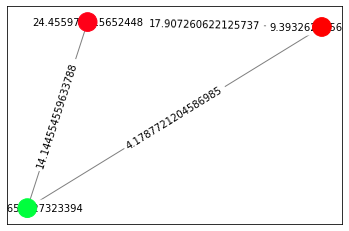

In [64]:
# draw the graph
pos = nx.spring_layout(cluster_graph)
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', len(list(cluster_graph.nodes))*10)
cluster_weights = nx.get_edge_attributes(cluster_graph, 'weight')
nx.draw_networkx_nodes(cluster_graph, pos, node_size=350,
                       cmap=cmap, node_color=[i for i in list(cluster_graph.nodes)])
nx.draw_networkx_edges(cluster_graph, pos, alpha=0.5)
nx.draw_networkx_edge_labels(cluster_graph, pos, edge_labels=cluster_weights)
plt.show()

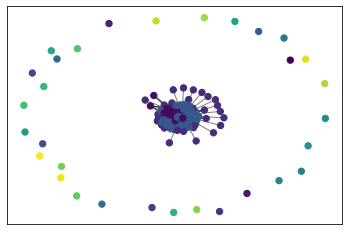

In [65]:
# draw the graph
pos = nx.spring_layout(artist_graph_from_corr)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(artist_graph_from_corr, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(artist_graph_from_corr, pos, alpha=0.5)
plt.show()